In [38]:
df = pd.read_csv('../data/processed/structure_prediction_transferability_consolidated_results.csv')
df = df.loc[df.SCOPE.isin(['insider', 'visitor'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28080 entries, 10800 to 41039
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CV_FOLD           10800 non-null  float64
 1   DATA_SOURCE       28080 non-null  object 
 2   METRIC            28080 non-null  object 
 3   MODEL             28080 non-null  object 
 4   SCOPE             28080 non-null  object 
 5   SCORE             28080 non-null  float64
 6   TARGET            28080 non-null  object 
 7   TARGET_ECOREGION  28080 non-null  object 
 8   TRAIN_ECOREGION   28080 non-null  object 
 9   ECOREGION_LABEL   28080 non-null  object 
dtypes: float64(2), object(8)
memory usage: 2.4+ MB


In [39]:
glob_sat = pd.read_csv('../data/processed/nestedcv_chained_global_results_satellite_structure.csv')
glob_sat['DATA_SOURCE'] = 'satellite'
glob_lid = pd.read_csv('../data/processed/nestedcv_chained_global_results_lidar_structure.csv')
glob_lid['DATA_SOURCE'] = 'lidar'
glob_df = (pd.concat([glob_sat, glob_lid], axis=0, ignore_index=True)
           .rename({'ECOREGION': 'TARGET_ECOREGION'}, axis=1))
glob_df['TRAIN_ECOREGION'] = 'GLOBAL'
glob_df['SCOPE'] = 'global'
glob_df['ECOREGION_LABEL'] = 'Global'
glob_df.head()

,CV_FOLD,TARGET_ECOREGION,TARGET,METRIC,SCORE,MODEL,DATA_SOURCE,TRAIN_ECOREGION,SCOPE,ECOREGION_LABEL
0,1,Blue Mountains,total_cover,rmse,10.313029,ElasticNet,satellite,GLOBAL,global,Global
1,1,Blue Mountains,total_cover,nrmse,0.299894,ElasticNet,satellite,GLOBAL,global,Global
2,1,Blue Mountains,total_cover,mae,8.691027,ElasticNet,satellite,GLOBAL,global,Global
3,1,Blue Mountains,total_cover,mape,0.252728,ElasticNet,satellite,GLOBAL,global,Global
4,1,Blue Mountains,total_cover,bias,-1.658816,ElasticNet,satellite,GLOBAL,global,Global


In [40]:
df = pd.concat([df, glob_df], axis=0, sort=True, ignore_index=True)

In [41]:
RENAME = {
    'Blue Mountains': 'BM', 
    'Cascades': 'WC', 
    'Coast Range': 'CR', 
    'Eastern Cascades': 'EC',
    'Eastern Cascades Slopes And Foothills': 'EC', 
    'Klamath Mountains': 'KM',
    'Klamath Mountains California High North Coast Range': 'KM',
    'North Cascades': 'NC', 
    'Northern Rockies': 'NR', 
    'Puget Lowland': 'PL',
    'Willamette Valley': 'WV',
}
df[['TRAIN_ECOREGION', 'TARGET_ECOREGION']] = df[['TRAIN_ECOREGION', 'TARGET_ECOREGION']].replace(RENAME)

In [42]:
df.head()

,CV_FOLD,DATA_SOURCE,ECOREGION_LABEL,METRIC,MODEL,SCOPE,SCORE,TARGET,TARGET_ECOREGION,TRAIN_ECOREGION
0,1.0,lidar,Blue Mountains,rmse,ElasticNet,insider,6.889208,total_cover,BM,BM
1,1.0,lidar,Blue Mountains,nrmse,ElasticNet,insider,0.202975,total_cover,BM,BM
2,1.0,lidar,Blue Mountains,mae,ElasticNet,insider,5.652041,total_cover,BM,BM
3,1.0,lidar,Blue Mountains,mape,ElasticNet,insider,0.166525,total_cover,BM,BM
4,1.0,lidar,Blue Mountains,bias,ElasticNet,insider,-0.321978,total_cover,BM,BM


In [145]:
pd.unique(df.loc[(df.MODEL == 'GBM')&(df.METRIC == 'nrmse')]['SCOPE'])

array(['insider', 'visitor', 'global'], dtype=object)

In [43]:
from shapely.geometry import Point
import geopandas as gpd
PLOT_FEATS = ['lat', 'lon', 'ecoregion3']
plot_loc = pd.read_csv('../data/processed/plot_features.csv')
plot_loc.head()

,uuid,lat,lon,orig_id,source,meas_yr,ecoregion3,agency,plot_size_ac,bulk_dens,soil_depth,pct_clay_surf,pct_rock_surf,pct_sand_surf,distance_to_water_m,pot_veg_type
0,00027724,44.656847,-118.217206,061609823230090,USFS-BLUE-MOUNTAINS,2015,blue_mountains,USFS,0.250,106,118.0,18,22,16,89.723536,1159
1,0080963b,43.028673,-123.898747,72-04,BLM-COOS,2011,coast_range,BLM,0.125,103,113.0,23,16,33,180.194859,1037
2,0083eb5e,46.486165,-121.091325,0083eb5e-aed6-4c22-9412-bc116d072ed9,WA-DNR,2013,eastern_cascades_slopes_and_foothills,WADNR,0.100,128,113.0,20,25,34,0.604645,1018
3,008dc9d1,48.178724,-121.981598,008dc9d1-d2a0-4ee5-ba75-592318d06c1b,WA-DNR,2014,north_cascades,WADNR,0.100,97,99.0,13,29,42,1237.148141,1039
4,00900e38,43.771495,-123.753809,73-25,BLM-COOS,2010,coast_range,BLM,0.125,103,113.0,23,16,33,64.718200,1039


In [104]:
from shapely.geometry import Point
import geopandas as gpd
PLOT_FEATS = ['lat', 'lon', 'ecoregion3', 'agency']
plot_loc = pd.read_csv('../data/processed/plot_features.csv')[PLOT_FEATS]
plot_loc['geometry'] = plot_loc.apply(lambda row: Point(row.lat, row.lon), axis=1)
plot_loc = gpd.GeoDataFrame(plot_loc, crs=4326).to_crs(6339)
REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV']

RENAME_LOC = {
    'blue_mountains': 'BM',
    'cascades': 'WC',
    'coast_range': 'CR',
    'columbia_plateau': 'CP',
    'eastern_cascades_slopes_and_foothills': 'EC',
    'klamath_mountains_california_high_north_coast_range': 'KM',
    'northern_basin_and_range': 'NB',
    'north_cascades': 'NC',
    'northern_rockies': 'NR',
    'puget_lowland': 'PL',
    'willamette_valley': 'WV'
}
plot_loc['ecoregion'] = plot_loc.ecoregion3.replace(RENAME_LOC)
plot_loc['x'] = plot_loc.geometry.x
plot_loc['y'] = plot_loc.geometry.y

centroids = plot_loc.groupby(by='ecoregion')[['x', 'y']].median()
centroids.loc['GLOBAL'] = plot_loc[['x', 'y']].median()
centroids.loc[:] = centroids.values - centroids.median().values
centroids = centroids.reindex(REGIONS+['GLOBAL']) / centroids.abs().max().max()

centroids

,x,y
ecoregion,,
BM,0.707880,-0.349615
CR,-0.349737,-0.499540
EC,0.165837,0.099105
KM,-0.283579,-0.890948
NC,0.054273,0.586263
NR,0.732880,0.673961
PL,-0.156915,0.455795
WC,-0.054273,-0.037965
WV,-0.234784,-0.603645


In [45]:
plot_loc.loc[plot_loc.ecoregion == 'CR'].groupby(by='agency')['lat'].count()

agency
BLM      936
WADNR    882
Name: lat, dtype: int64

In [46]:
def get_distance_matrix(target, model, data_source, metric='nrmse', zero_self=False):
    query = f'TARGET == "{target}" and METRIC == "{metric}" and MODEL == "{model}" and DATA_SOURCE == "{data_source}" and SCOPE == "visitor"'
    visitor_df = df.query(query)
    query = f'TARGET == "{target}" and METRIC == "{metric}" and MODEL == "{model}" and DATA_SOURCE == "{data_source}" and SCOPE == "insider"'
    insider_df = df.query(query).groupby(by=['TRAIN_ECOREGION', 'TARGET_ECOREGION'])['SCORE'].mean().reset_index()
    to_pivot = pd.concat([visitor_df, insider_df], axis=0, ignore_index=True)
    pivot = pd.pivot_table(to_pivot, index='TRAIN_ECOREGION', columns='TARGET_ECOREGION', values='SCORE')
    if zero_self:
        np.fill_diagonal(pivot.values, 0)
    return pivot

In [47]:
def get_global_distance_matrix(target, model, data_source, metric='nrmse', zero_self=False):
    query = f'TARGET == "{target}" and METRIC == "{metric}" and MODEL == "{model}" and DATA_SOURCE == "{data_source}" and SCOPE == "global"'
    glob_df = df.query(query).groupby(by=['TRAIN_ECOREGION', 'TARGET_ECOREGION'])['SCORE'].mean().reset_index()
    return glob_df.pivot('TRAIN_ECOREGION', 'TARGET_ECOREGION', 'SCORE') 

In [57]:
TARGS = ['total_cover', 'topht', 'qmd', 'tcuft']
MODELS  = ['ElasticNet', 'GBM', 'Lasso', 'RF', 'kNN']
DATA_SOURCES = ['satellite', 'lidar']
REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV']

lidar_dists = []
satellite_dists = []
for target in TARGS:
    for model in MODELS:
        for ds in DATA_SOURCES:
            dist = get_distance_matrix(target, model, ds).values
            if ds == 'lidar':
                lidar_dists.append(dist)
            elif ds == 'satellite':
                satellite_dists.append(dist)

lidar_dist_df = get_distance_matrix(target, model, ds)
sat_dist_df = lidar_dist_df.copy()

lidar_dist = np.stack(lidar_dists, axis=0)
sat_dist = np.stack(satellite_dists, axis=0)

lidar_dist_df.loc[:,:] = lidar_dist.mean(axis=0)
sat_dist_df.loc[:,:] = sat_dist.mean(axis=0)

In [58]:
(lidar_dist_df.style.background_gradient(cmap ='viridis', axis=None, vmin=0.25, vmax=1.3)
 .format("{:.2f}"))

TARGET_ECOREGION,BM,CR,EC,KM,NC,NR,PL,WC,WV
TRAIN_ECOREGION,,,,,,,,,
BM,0.25,1.10,0.67,0.99,1.13,0.77,1.06,0.93,1.07
CR,0.68,0.31,0.42,0.44,0.62,0.68,0.51,0.30,0.26
EC,0.39,1.02,0.32,0.55,3.28,0.82,2.88,0.88,0.49
KM,0.64,0.39,0.47,0.43,0.69,0.71,0.56,0.36,0.31
NC,0.48,0.39,0.41,0.59,0.32,0.45,0.30,0.35,0.33
NR,0.40,0.49,0.43,0.60,0.53,0.39,0.49,0.42,0.42
PL,0.79,0.43,0.48,0.60,0.39,0.49,0.32,0.40,0.37
WC,0.70,0.33,0.44,0.48,0.55,0.64,0.45,0.27,0.25
WV,0.79,0.42,0.56,0.58,0.62,0.85,0.49,0.36,0.26


In [59]:
(sat_dist_df.style.background_gradient(cmap ='viridis', axis=None, vmin=0.25, vmax=1.3)
 .format("{:.2f}"))

TARGET_ECOREGION,BM,CR,EC,KM,NC,NR,PL,WC,WV
TRAIN_ECOREGION,,,,,,,,,
BM,0.34,0.61,0.53,0.65,0.60,0.61,0.57,0.56,0.57
CR,1.48,0.37,0.93,0.61,0.59,1.10,0.49,0.43,0.36
EC,0.65,0.49,0.42,0.55,0.45,0.66,0.45,0.45,0.45
KM,1.37,0.47,0.96,0.48,0.78,1.57,0.61,0.50,0.40
NC,0.51,0.47,0.62,0.73,0.40,0.80,0.44,0.46,0.47
NR,0.68,0.63,0.60,0.86,0.52,0.46,0.52,0.61,0.63
PL,1.75,0.46,0.93,0.55,0.56,1.20,0.42,0.42,0.44
WC,1.00,0.40,0.68,0.59,0.45,0.85,0.45,0.37,0.38
WV,2.19,0.45,1.23,0.67,0.74,1.49,0.57,0.56,0.39


In [60]:
# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# sns.heatmap(dist_df, cmap='viridis', ax=ax)
# plt.show()

In [61]:
TRG = 'qmd'
MET = 'nrmse'
MOD = 'ElasticNet'
DS = 'lidar'
query = f'TARGET == "{TRG}" and METRIC == "{MET}" and MODEL == "{MOD}" and DATA_SOURCE == "{DS}" and SCOPE == "global"'
df.query(query).query('TARGET_ECOREGION == "BM"')

,CV_FOLD,DATA_SOURCE,ECOREGION_LABEL,METRIC,MODEL,SCOPE,SCORE,TARGET,TARGET_ECOREGION,TRAIN_ECOREGION
33493,1.0,lidar,Global,nrmse,ElasticNet,global,0.250307,qmd,BM,GLOBAL
33709,2.0,lidar,Global,nrmse,ElasticNet,global,0.251719,qmd,BM,GLOBAL
33925,3.0,lidar,Global,nrmse,ElasticNet,global,0.262885,qmd,BM,GLOBAL
34141,4.0,lidar,Global,nrmse,ElasticNet,global,0.313692,qmd,BM,GLOBAL
34357,5.0,lidar,Global,nrmse,ElasticNet,global,0.254752,qmd,BM,GLOBAL


In [62]:
def get_graph_df(target, model, data_source, metric='nrmse'):
    query = f'TARGET == "{target}" and METRIC == "{metric}" and MODEL == "{model}" and DATA_SOURCE == "{data_source}" and SCOPE == "visitor"'
    visitor_df = df.query(query)
    query = f'TARGET == "{target}" and METRIC == "{metric}" and MODEL == "{model}" and DATA_SOURCE == "{data_source}" and SCOPE == "insider"'
    insider_df = df.query(query).groupby(by=['TRAIN_ECOREGION', 'TARGET_ECOREGION'])['SCORE'].mean().reset_index()
    query = f'TARGET == "{target}" and METRIC == "{metric}" and MODEL == "{model}" and DATA_SOURCE == "{data_source}" and SCOPE == "global"'
    glob_df = df.query(query).groupby(by=['TRAIN_ECOREGION', 'TARGET_ECOREGION'])['SCORE'].mean().reset_index()
    graph_df = pd.concat([visitor_df, insider_df, glob_df], axis=0, sort=True, ignore_index=True)
    return graph_df

def get_kk_layout(target, model, data_source, metric='nrmse', pos=None, dim=2):
    REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV', 'GLOBAL']
    graph_df = get_graph_df(target, model, data_source, metric)
    
    dist_dict = {source:{} for source in REGIONS}
    for source in REGIONS:
        for target in REGIONS[:-1]:  # leave off global, never a target
            dist_dict[source][target] = graph_df.query(
                f'TARGET_ECOREGION == "{target}" and TRAIN_ECOREGION == "{source}"')['SCORE'].values[0]
    
    G = nx.from_pandas_edgelist(df=graph_df,
                                source='TRAIN_ECOREGION', 
                                target='TARGET_ECOREGION', 
                                edge_attr='SCORE', 
                                create_using=nx.DiGraph(directed=True))
    layout = nx.kamada_kawai_layout(G, 
                                    dist=dist_dict, 
#                                     weight='SCORE', 
                                    center=np.zeros(dim), 
                                    scale=graph_df['SCORE'].mean(),
                                    pos=pos, dim=dim)
    return layout

def get_points_from_kk_layout(layout):
    REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV', 'GLOBAL']
    pts = np.stack([layout[reg] for reg in REGIONS])
    return pts

def get_kk_points(target, model, data_source, metric='nrmse', pos=None, dim=2):
    layout = get_kk_layout(target, model, data_source, metric, dim=dim)
    pts = get_points_from_kk_layout(layout)
    return pts

# For 3D visualization

In [266]:
TARGS = ['total_cover', 'topht', 'qmd', 'tcuft']
MODELS  = ['ElasticNet', 'GBM', 'Lasso', 'RF', 'kNN']
DATA_SOURCES = ['satellite', 'lidar']
REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV', 'GLOBAL']

all_pts_3d = {ds: {mod: {targ: None for targ in TARGS} for mod in MODELS} for ds in DATA_SOURCES}
target = None
for ds in DATA_SOURCES:
    for mod in MODELS:
        for targ in TARGS:
            if target is None:
                target = get_kk_points(targ, mod, ds, dim=3)
                all_pts_3d[ds][mod][targ] = target

            else:
                pos = {reg:loc for reg, loc in zip(REGIONS, target)}
                source = get_kk_points(targ, mod, ds, pos=pos, dim=3)
                source_mean = source.mean(axis=0)
                target_mean = target.mean(axis=0)
                source_norm = source - source_mean
                target_norm = target - target_mean
                
                R, s = orthogonal_procrustes(target_norm, source_norm)
                t = -R.T@source_mean + target_mean
                reproj = np.dot(source, R.T) + t
                all_pts_3d[ds][mod][targ] = reproj

In [64]:
cmap = sns.color_palette('colorblind', n_colors=9)
cmap.append((0,0,0))
REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV', 'GLOBAL']
fig = ipv.figure(width=1000, height=1000)

xs, ys, zs = [], [], []
xmin, xmax = 0, 0
ymin, ymax = 0, 0
zmin, zmax = 0, 0
for ds in DATA_SOURCES:
    for mod in MODELS:
        for i, region in enumerate(REGIONS):
            all_pts = []
            for targ in range(4):
                all_pts.append(all_pts_3d[ds][mod][targ][i])

            pts = np.array(all_pts)
            x, y, z = pts[:,0], pts[:,1], pts[:,2]
            xmin, ymin, zmin = min(xmin, x.min()), min(ymin, y.min()), min(zmin, z.min())
            xmax, ymax, zmax = max(xmax, x.max()), max(ymax, y.max()), max(zmax, z.max())
            ipv.scatter(x,y,z, color=np.tile(np.array(cmap[i]), (4,1)), marker='sphere', size=2)

fig.xlim = (xmin, xmax)
fig.ylim = (ymin, ymax)
fig.zlim = (zmin, zmax)
ipv.show()

In [65]:
cmap = sns.color_palette('colorblind', n_colors=9)
cmap.append((0,0,0))
REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV', 'Global']
fig = ipv.figure()

xs, ys, zs = [], [], []
xmin, xmax = 0, 0
ymin, ymax = 0, 0
zmin, zmax = 0, 0
for mod in MODELS:
    for i, region in enumerate(REGIONS):
        all_pts = []
        for targ in range(4):
            all_pts.append(all_pts_3d['lidar'][mod][targ][i])
        
        pts = np.array(all_pts)
        x, y, z = pts[:,0], pts[:,1], pts[:,2]
        xmin, ymin, zmin = min(xmin, x.min()), min(ymin, y.min()), min(zmin, z.min())
        xmax, ymax, zmax = max(xmax, x.max()), max(ymax, y.max()), max(zmax, z.max())
        ipv.scatter(x,y,z, color=np.tile(np.array(cmap[i]), (4,1)), marker='sphere', size=3)

fig.xlim = (xmin, xmax)
fig.ylim = (ymin, ymax)
fig.zlim = (zmin, zmax)
ipv.show()

In [260]:
centroids

,x,y
ecoregion,,
BM,0.707880,-0.349615
CR,-0.349737,-0.499540
EC,0.165837,0.099105
KM,-0.283579,-0.890948
NC,0.054273,0.586263
NR,0.732880,0.673961
PL,-0.156915,0.455795
WC,-0.054273,-0.037965
WV,-0.234784,-0.603645


# For 2D visualization

In [267]:
TARGS = ['total_cover', 'topht', 'qmd', 'tcuft']
MODELS  = ['ElasticNet', 'GBM', 'Lasso', 'RF', 'kNN']
DATA_SOURCES = ['satellite', 'lidar']
REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV', 'GLOBAL']

# we will initialize the locations of each graph with geolocations
geoloc = centroids.reindex(REGIONS[:-1]).values
pos = {reg:loc for reg, loc in zip(REGIONS, geoloc)}

all_pts_2d = {ds: {mod: {targ: None for targ in TARGS} for mod in MODELS} for ds in DATA_SOURCES}
target = None
for ds in DATA_SOURCES:
    for mod in MODELS:
        for targ in TARGS:
            source = get_kk_points(targ, mod, ds, pos=pos, dim=2)
            source_mean = source.mean(axis=0)
            target_mean = geoloc.mean(axis=0)
            source_norm = source - source_mean
            target_norm = geoloc - target_mean
            R, s = orthogonal_procrustes(target_norm, source_norm[:-1])
            t = -R.T@source_mean + target_mean
            reproj = np.dot(source_norm, R.T) + t
            all_pts_2d[ds][mod][targ] = reproj

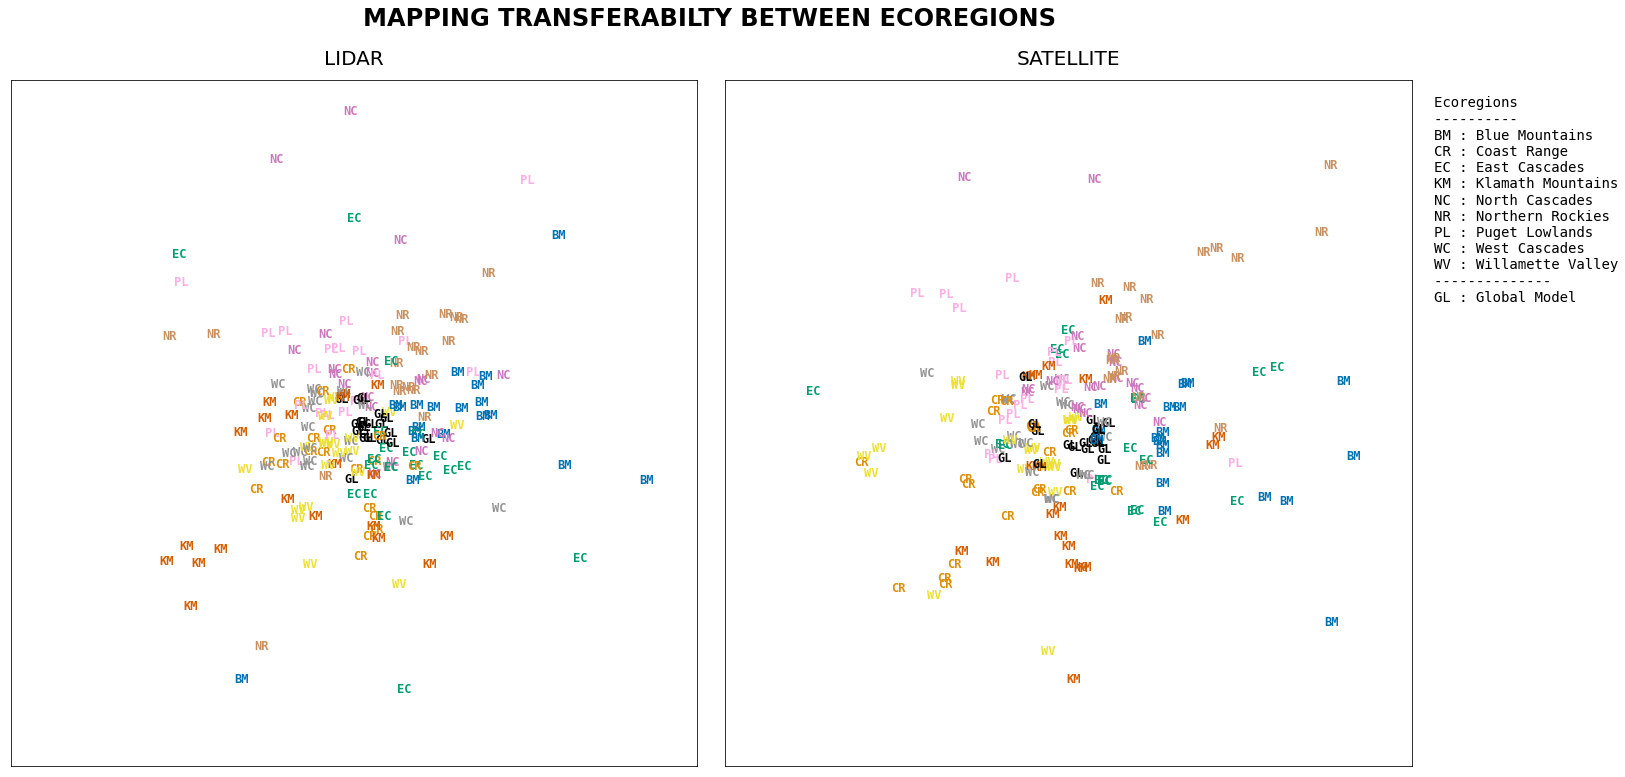

In [67]:
cmap = sns.color_palette('colorblind', n_colors=9)
cmap.append((0,0,0))

REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV', 'GL']
fig, axs= plt.subplots(1,2, figsize=(20,10))
for i, ds in enumerate(['lidar', 'satellite']):
    axs[i].set_title(ds.upper(), fontsize=20, pad=15)
    for mod in MODELS:
        for pt_set in all_pts_2d[ds][mod]:
            for j, pts in enumerate(pt_set):
                axs[i].scatter(pts[0], pts[1], color=cmap[j], s=0)
                t = axs[i].text(pts[0], pts[1], REGIONS[j], color=cmap[j], 
                                fontweight='bold', family='monospace', fontsize=12)
for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    DIST = 1.5
    ax.set_xlim(-DIST, DIST)
    ax.set_ylim(-DIST, DIST)
    ax.set_aspect('equal') 


plt.suptitle('Mapping Transferabilty between Ecoregions'.upper(), 
             x=0.5, y=1.07, fontsize=24, fontweight='bold')
plt.tight_layout()
axs[1].text(0.87*DIST, DIST, 
        """
        Ecoregions
        ----------
        BM : Blue Mountains
        CR : Coast Range
        EC : East Cascades
        KM : Klamath Mountains
        NC : North Cascades
        NR : Northern Rockies
        PL : Puget Lowlands
        WC : West Cascades
        WV : Willamette Valley
        --------------
        GL : Global Model
        """, 
        fontsize=14, va='top', family='monospace')
plt.savefig('../reports/figures/visitor_transferability_all_targets_kamada_kawai.png', dpi=300, bbox_inches='tight')
plt.show()

In [259]:
geoloc.shape

(10, 2)

In [79]:
def get_scale(target, data_source, metric='nrmse'):
    query = f'TARGET == "{target}" and METRIC == "{metric}" and DATA_SOURCE == "{data_source}" and SCOPE == "visitor"'
    visitor_df = df.query(query)
    query = f'TARGET == "{target}" and METRIC == "{metric}" and DATA_SOURCE == "{data_source}" and SCOPE == "insider"'
    insider_df = df.query(query).groupby(by=['TRAIN_ECOREGION', 'TARGET_ECOREGION'])['SCORE'].mean().reset_index()
    query = f'TARGET == "{target}" and METRIC == "{metric}" and DATA_SOURCE == "{data_source}" and SCOPE == "global"'
    glob_df = df.query(query).groupby(by=['TRAIN_ECOREGION', 'TARGET_ECOREGION'])['SCORE'].mean().reset_index()
    graph_df = pd.concat([visitor_df, insider_df, glob_df], axis=0, sort=True, ignore_index=True)
    return graph_df['SCORE'].mean()

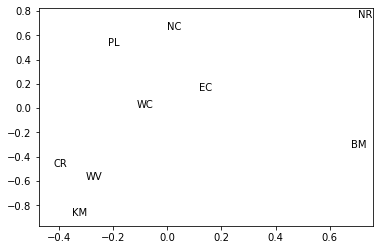

In [68]:
fig, ax = plt.subplots()
for i, reg in enumerate(REGIONS[:-1]):
    x, y = centroids.loc[reg, ['x', 'y']]
    ax.text(x, y, reg)
    ax.scatter(x, y, s=0)
plt.show()

In [199]:
get_graph_df('qmd', 'Lasso', 'satellite')['SCORE'].mean()

0.6963217686503446

In [206]:
euclidean_distances(pt_set)[euclidean_distances(pt_set)>0].mean()

1.0781746625959363

In [165]:
get_insider_error('qmd', 'satellite')

,TARGET_ECOREGION,SCORE
0,BM,0.273300
1,CR,0.457074
2,EC,0.421740
3,KM,0.707844
4,NC,0.427731
5,NR,0.538395
6,PL,0.425141
7,WC,0.418747
8,WV,0.453712


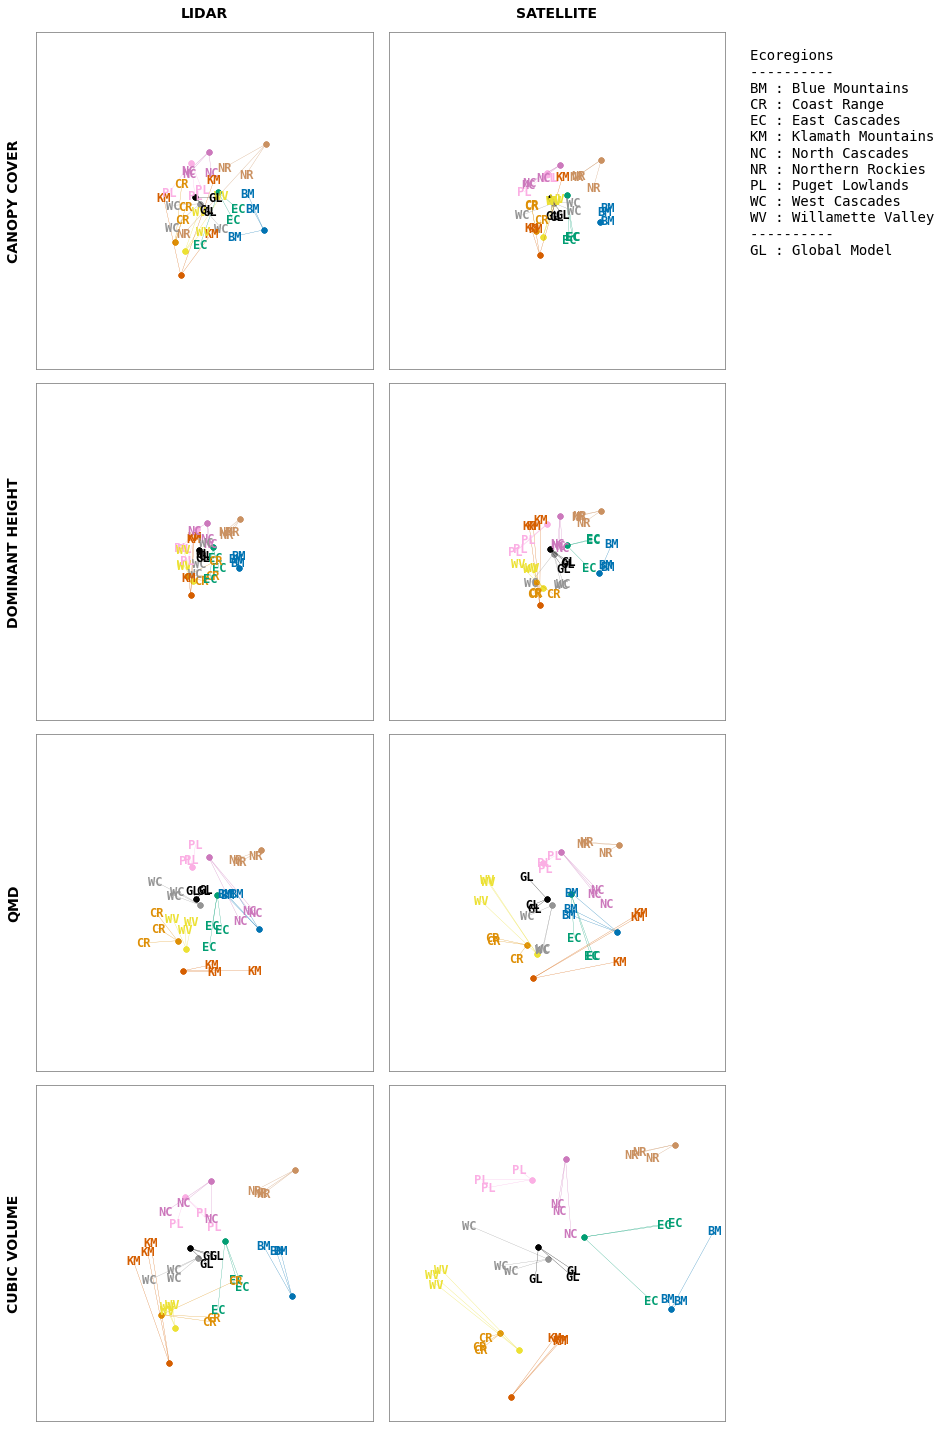

In [139]:
cmap = sns.color_palette('colorblind', n_colors=9)
cmap.append((0,0,0))

# MODELS = ['ElasticNet', 'GBM', 'Lasso', 'RF', 'kNN']
MODELS = ['GBM', 'RF', 'kNN']
REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV', 'GL']
TARG_COLS = ['total_cover', 'topht', 'qmd', 'tcuft']
TARGETS = ['Canopy Cover', 'Dominant Height', 'QMD', 'Cubic Volume']
fig, axs = plt.subplots(4, 2, figsize=(10.5,20), sharex=True, sharey=True)
for col, ds in enumerate(['lidar', 'satellite']):
    axs[0, col].set_title(ds.upper(), fontsize=14, pad=15, fontweight='bold')
    for k, mod in enumerate(MODELS):
        for i, pt_set in enumerate(all_pts_2d[ds][mod]):
            pt_scale = euclidean_distances(pt_set)[euclidean_distances(pt_set)>0].mean()
            err_scale = get_scale(TARG_COLS[i], ds)
            scale = pt_scale / err_scale
            scaled_centroids = centroids.values * scale
            for j, pts in enumerate(pt_set):
                axs[i, col].scatter(pts[0], pts[1], color=cmap[j], s=0)
                t = axs[i, col].text(pts[0], pts[1], 
                                     REGIONS[j], color=cmap[j], 
                                     fontweight='heavy',
                                     ha='center', va='center', 
                                     fontsize=12, family='monospace',
#                                      path_effects=[path_effects.withStroke(linewidth=3,
#                                                                            foreground="w")]
                                    )
                # Plot scaled geographic centroids
                axs[i, col].scatter(scaled_centroids[j,0], scaled_centroids[j,1], 
                                    color=cmap[j], s=25.0)
                # Plot lines from each point to the geographic centroid
                axs[i,col].plot([pts[0], scaled_centroids[j,0]], 
                                [pts[1], scaled_centroids[j,1]], 
                                color=cmap[j], lw=0.25)

            axs[i, col].set_aspect('equal')
            DIST = 1.6 if 'Lasso' in MODELS else 1.25
            axs[i, col].set_xlim(-DIST,DIST)
            axs[i, col].set_ylim(-DIST,DIST)
            axs[i, col].set_xticks([])
            axs[i, col].set_yticks([])
            axs[i, 0].set_ylabel(TARGETS[i].upper(), fontsize=14, labelpad=15, fontweight='bold')
            axs[i, col].spines['bottom'].set_color('gray')
            axs[i, col].spines['top'].set_color('gray') 
            axs[i, col].spines['right'].set_color('gray')
            axs[i, col].spines['left'].set_color('gray')
plt.tight_layout()

axs[0,1].text(0.75*DIST, DIST, 
        """
        Ecoregions
        ----------
        BM : Blue Mountains
        CR : Coast Range
        EC : East Cascades
        KM : Klamath Mountains
        NC : North Cascades
        NR : Northern Rockies
        PL : Puget Lowlands
        WC : West Cascades
        WV : Willamette Valley
        ----------
        GL : Global Model
        """, 
        fontsize=14, va='top', family='monospace')
plt.savefig('../reports/figures/visitor_transferability_by_target_kamada_kawai.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [235]:
def get_insider_error(target, model, data_source, metric='nrmse'):
    query = f'TARGET == "{target}" and MODEL == "{model}" and METRIC == "{metric}" and DATA_SOURCE == "{data_source}" and SCOPE == "insider"'
    insider_df = df.query(query).groupby(by=['TRAIN_ECOREGION', 'TARGET_ECOREGION'])['SCORE'].mean().reset_index()
    return insider_df[['TARGET_ECOREGION', 'SCORE']]

def get_global_error(target, model, data_source, metric='nrmse'):
    query = f'TARGET == "{target}" and MODEL == "{model}" and METRIC == "{metric}" and DATA_SOURCE == "{data_source}" and SCOPE == "global"'
    glob_df = df.query(query).groupby(by=['TRAIN_ECOREGION', 'TARGET_ECOREGION'])['SCORE'].mean().reset_index()
    return glob_df[['TARGET_ECOREGION', 'SCORE']]

def get_visitor_error(target, model, data_source, metric='nrmse'):
    query = f'TARGET == "{target}" and MODEL == "{model}" and METRIC == "{metric}" and DATA_SOURCE == "{data_source}" and SCOPE == "visitor"'
    vis_df = df.query(query)
    return vis_df[['TRAIN_ECOREGION', 'TARGET_ECOREGION', 'SCORE']]

def get_scales(target, model, data_source, metric='nrmse'):
    query = f'TARGET == "{target}" and METRIC == "{metric}" and MODEL == "{model}" and DATA_SOURCE == "{data_source}" and SCOPE == "visitor"'
    visitor_df = df.query(query)
    query = f'TARGET == "{target}" and METRIC == "{metric}" and MODEL == "{model}" and DATA_SOURCE == "{data_source}" and SCOPE == "insider"'
    insider_df = df.query(query).groupby(by=['TRAIN_ECOREGION', 'TARGET_ECOREGION'])['SCORE'].mean().reset_index()
    query = f'TARGET == "{target}" and METRIC == "{metric}" and MODEL == "{model}" and DATA_SOURCE == "{data_source}" and SCOPE == "global"'
    glob_df = df.query(query).groupby(by=['TRAIN_ECOREGION', 'TARGET_ECOREGION'])['SCORE'].mean().reset_index()
    return visitor_df['SCORE'].mean(), visitor_df['SCORE'].std(), insider_df['SCORE'].mean(),insider_df['SCORE'].std(), glob_df['SCORE'].mean(), glob_df['SCORE'].std()

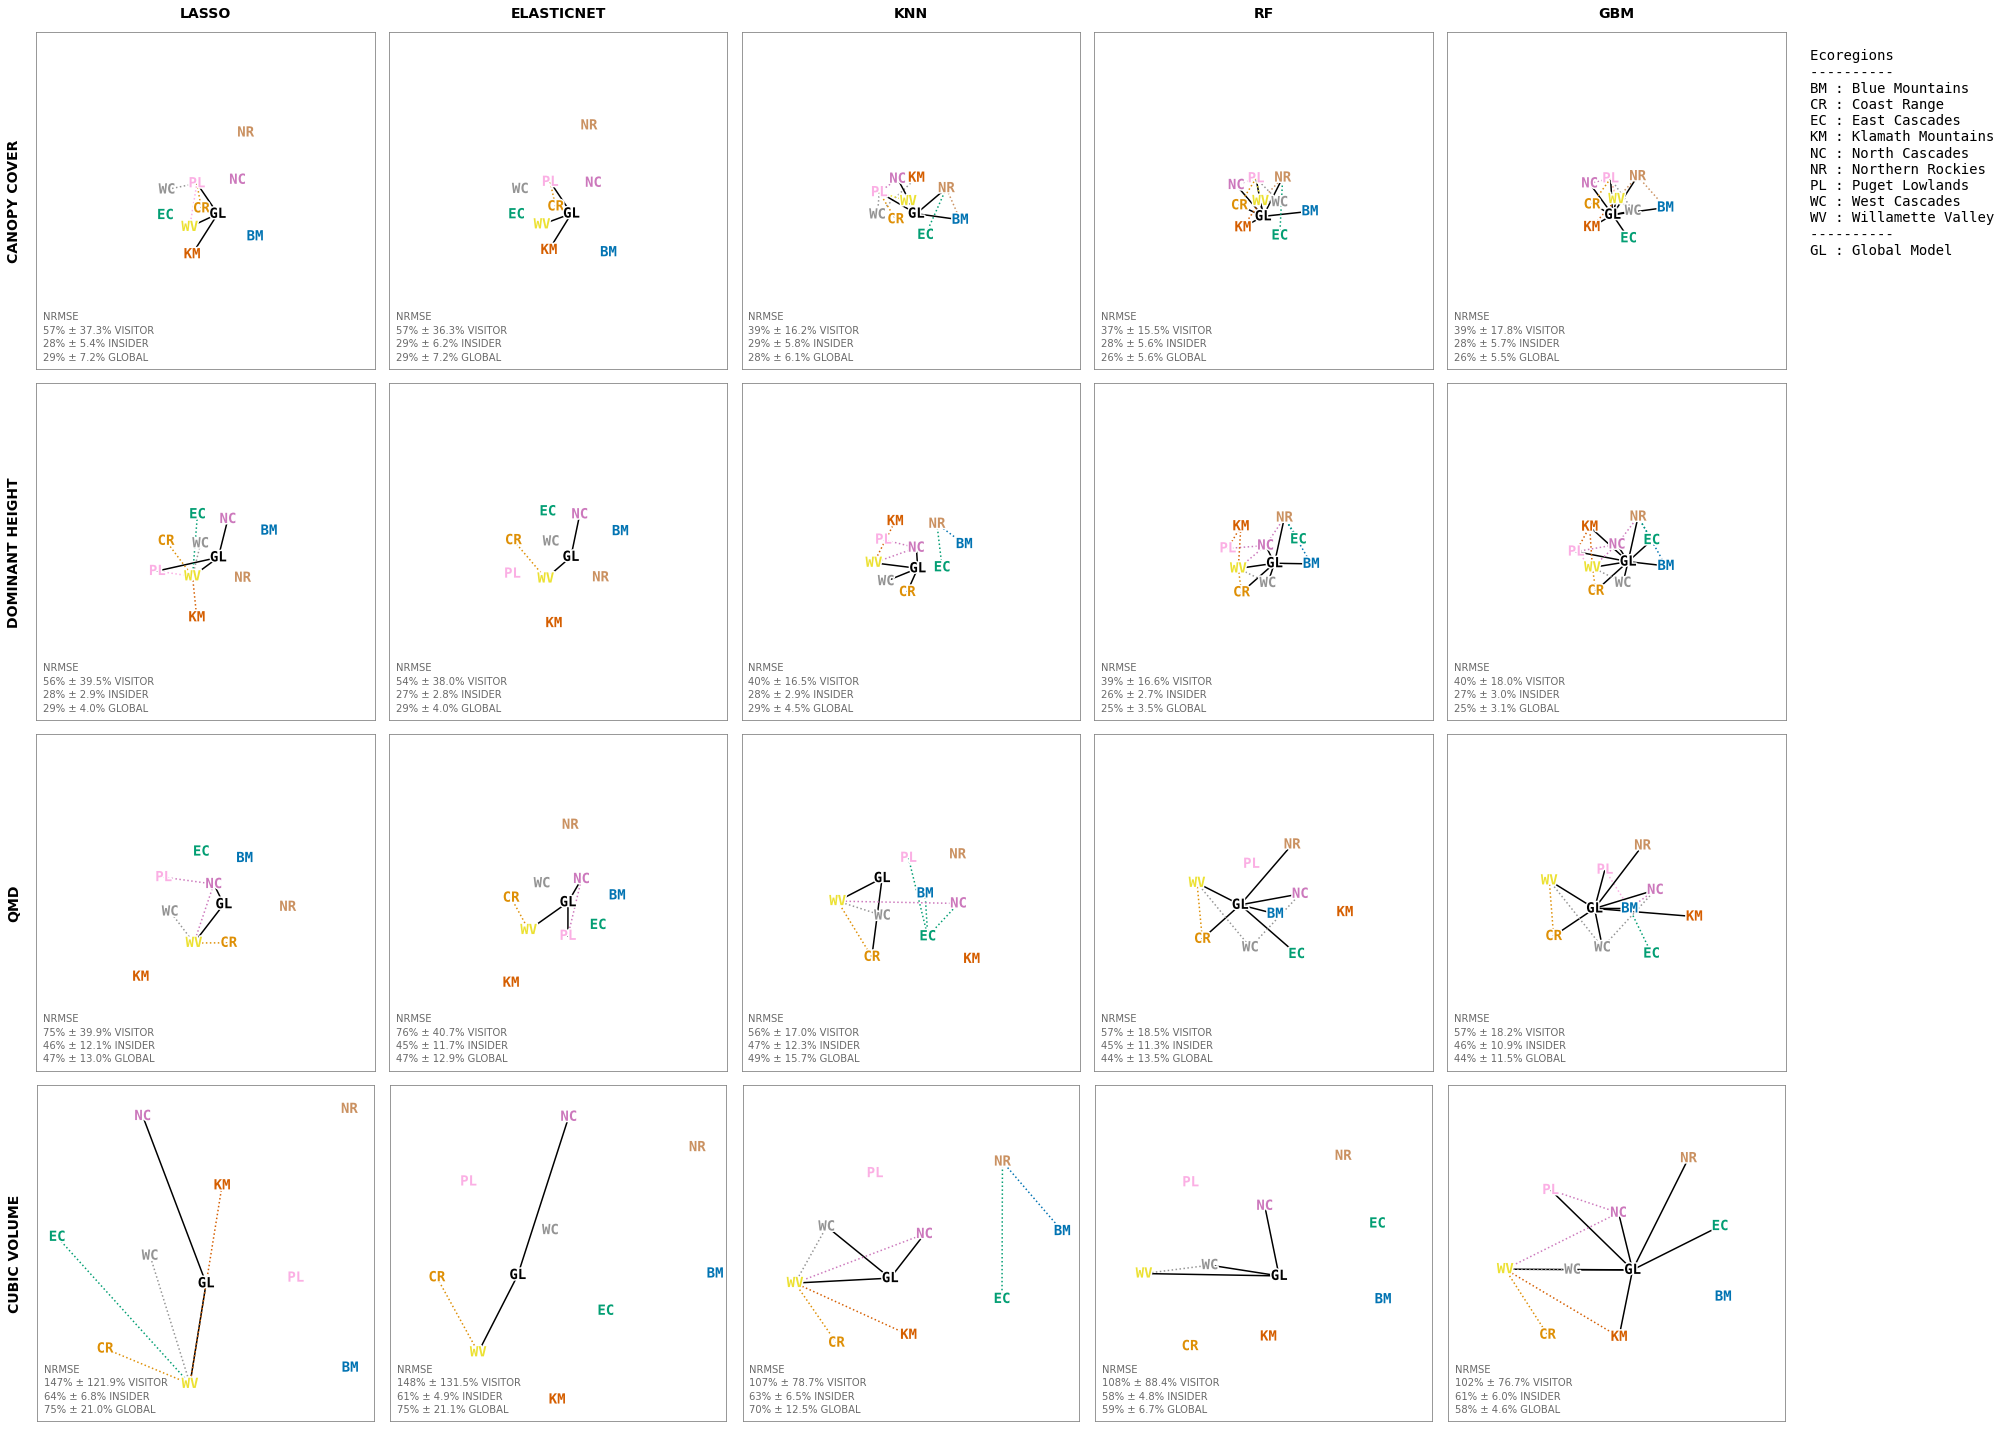

In [250]:
cmap = sns.color_palette('colorblind', n_colors=9)
cmap.append((0,0,0))

MODELS = ['Lasso', 'ElasticNet', 'kNN', 'RF', 'GBM']
# MODELS = ['GBM', 'RF', 'kNN']
REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV', 'GL']
TARG_COLS = ['total_cover', 'topht', 'qmd', 'tcuft']
TARGETS = ['Canopy Cover', 'Dominant Height', 'QMD', 'Cubic Volume']
fig, axs = plt.subplots(len(TARG_COLS), len(MODELS), 
                        figsize=(25,20), 
                        sharex='row', sharey='row')
for col, model in enumerate(MODELS):
# for col, ds in enumerate(['lidar', 'satellite']):
    axs[0, col].set_title(model.upper(), fontsize=14, pad=15, fontweight='bold')
#     for k, mod in enumerate(MODELS):
    for k, ds in enumerate([
#         'lidar', 
        'satellite'
        ]):
        for targ_num, pt_set in enumerate(all_pts_2d[ds][model]):
#             pt_scale = euclidean_distances(pt_set)[euclidean_distances(pt_set)>0].mean()
#             err_scale = get_graph_df(TARG_COLS[targ_num], model, ds, metric='nrmse')['SCORE'].mean()
#             scale = pt_scale / err_scale
            scale = 1.0
            scaled_centroids = centroids.values * scale
            vis_mu, vis_sig, ins_mu, ins_sig, glo_mu, glo_sig = get_scales(TARG_COLS[targ_num], model, ds, metric='nrmse')
            vis_mu_mae, vis_sig_mae, ins_mu_mae, ins_sig_mae, glo_mu_mae, glo_sig_mae = get_scales(TARG_COLS[targ_num], model, ds, metric='mae')
            axs[targ_num, col].text(0.02, 0.17, 'NRMSE', 
                                    ha='left', va='top', 
                                    color='dimgray',
                                    transform=axs[targ_num, col].transAxes)
            axs[targ_num, col].text(0.02, 0.13, 
                                    f'{vis_mu:0.0%} ± {vis_sig:0.1%} VISITOR', 
                                    ha='left', va='top', 
                                    color='dimgray',
                                    transform=axs[targ_num, col].transAxes)
            axs[targ_num, col].text(0.02, 0.09,
                                    f'{ins_mu:0.0%} ± {ins_sig:0.1%} INSIDER', 
                                    ha='left', va='top', 
                                    color='dimgray', 
                                    transform=axs[targ_num, col].transAxes)
            axs[targ_num, col].text(0.02, 0.05,
                                    f'{glo_mu:0.0%} ± {glo_sig:0.1%} GLOBAL', 
                                    ha='left', va='top', 
                                    color='dimgray', 
                                    transform=axs[targ_num, col].transAxes)
            
            # get insider errors to plot around each region
            insider_errors = get_insider_error(TARG_COLS[targ_num], model, ds)
            global_errors = get_global_error(TARG_COLS[targ_num], model, ds)
            visitor_errors = get_visitor_error(TARG_COLS[targ_num], model, ds)
            for j, pts in enumerate(pt_set):
                axs[targ_num, col].scatter(pts[0]*scale, pts[1]*scale, color=cmap[j], s=0)
                t = axs[targ_num, col].text(pts[0]*scale, pts[1]*scale, 
                                            REGIONS[j], color=cmap[j], 
                                            fontweight='heavy',
                                            ha='center', va='center', 
                                            fontsize=14, family='monospace',
                                            path_effects=[path_effects.withStroke(linewidth=3,
                                                                                  foreground="w")]
                                           )
                # Plot insider error around each region
                if j < (len(pt_set)-1):
                    ins, glob = insider_errors.iloc[j]['SCORE'], global_errors.iloc[j]['SCORE']
#                     radius = insider_errors.iloc[j]['SCORE'] #* insider_errors.iloc[j]['SCORE']/global_errors.iloc[j]['SCORE']
#                     circle = plt.Circle((pts[0]*scale, pts[1]*scale), radius, facecolor='none', edgecolor=cmap[j], zorder=0, alpha=0.25)
#                     axs[targ_num, col].add_patch(circle)
                    # if global model is more accurate than insider model, plot a line between global and region
                    if glob < ins:
                        axs[targ_num, col].plot([pts[0]*scale, pt_set[-1][0]*scale], [pts[1]*scale, pt_set[-1][1]*scale], color=cmap[-1], lw=1.5, zorder=2)
                
                for k, reg in enumerate(REGIONS):
                    if j != k and j < (len(pt_set)-1) and k < (len(pt_set)-1):
                        train_err = visitor_errors.loc[(visitor_errors.TARGET_ECOREGION == REGIONS[j])&(visitor_errors.TRAIN_ECOREGION == REGIONS[k])]['SCORE'].values[0]
                        if train_err < ins:
                            axs[targ_num, col].plot([pts[0]*scale, pt_set[k][0]*scale], 
                                                    [pts[1]*scale, pt_set[k][1]*scale], 
                                                    ls=':',
                                                    color=cmap[k], lw=1.5, zorder=2)
                    
#                 # Plot scaled geographic centroids
#                 axs[targ_num, col].scatter(scaled_centroids[j,0], scaled_centroids[j,1], 
#                                     color=cmap[j], s=25.0)
#                 # Plot lines from each point to the geographic centroid
#                 axs[targ_num, col].plot([pts[0], scaled_centroids[j,0]], 
#                                 [pts[1], scaled_centroids[j,1]], 
#                                 color=cmap[j], lw=0.25)

            axs[i, col].set_aspect('equal')
            DIST = 1.3
            axs[targ_num, col].set_xlim(-DIST,DIST)
            axs[targ_num, col].set_ylim(-DIST,DIST)
            axs[targ_num, col].set_xticks([])
            axs[targ_num, col].set_yticks([])
            axs[targ_num, 0].set_ylabel(TARGETS[targ_num].upper(), fontsize=14, labelpad=15, fontweight='bold')
            axs[targ_num, col].spines['bottom'].set_color('gray')
            axs[targ_num, col].spines['top'].set_color('gray') 
            axs[targ_num, col].spines['right'].set_color('gray')
            axs[targ_num, col].spines['left'].set_color('gray')
plt.tight_layout()

axs[0,-1].text(0.75*DIST, DIST, 
        """
        Ecoregions
        ----------
        BM : Blue Mountains
        CR : Coast Range
        EC : East Cascades
        KM : Klamath Mountains
        NC : North Cascades
        NR : Northern Rockies
        PL : Puget Lowlands
        WC : West Cascades
        WV : Willamette Valley
        ----------
        GL : Global Model
        """, 
        fontsize=14, va='top', family='monospace')
plt.savefig('../reports/figures/satellite_transferability_by_target_and_model_kamada_kawai.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [307]:
get_visitor_error('qmd', 'Lasso', 'satellite')

,TRAIN_ECOREGION,TARGET_ECOREGION,SCORE
19470,WC,BM,1.145113
19590,CR,BM,0.740362
19710,EC,BM,0.331607
19830,KM,BM,1.818700
19950,NC,BM,0.376426
...,...,...,...
27510,EC,WV,0.484087
27630,KM,WV,0.478078
27750,NC,WV,0.465495
27870,NR,WV,0.540451


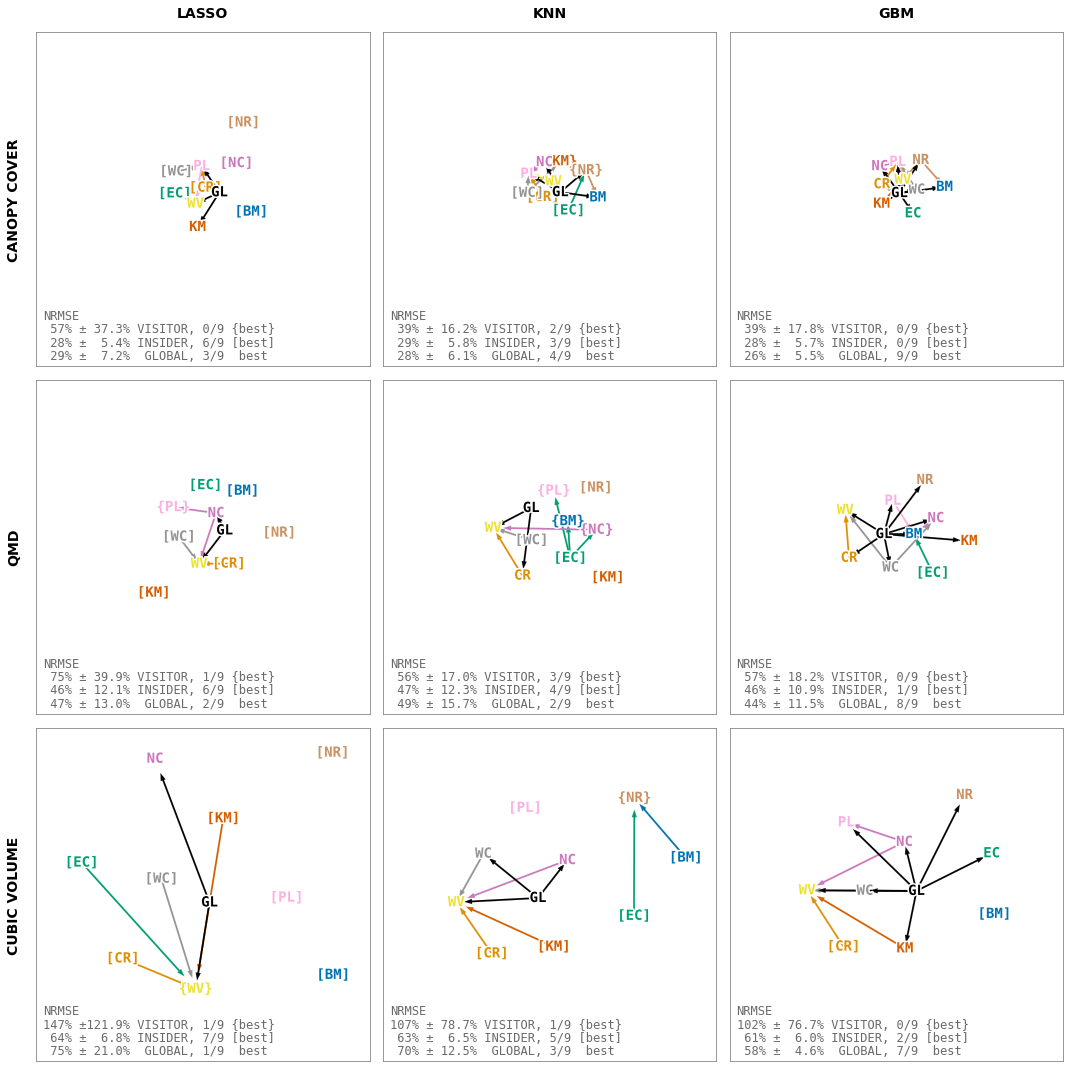

In [387]:
cmap = sns.color_palette('colorblind', n_colors=9)
cmap.append((0,0,0))

# MODELS = ['Lasso', 'ElasticNet', 'kNN', 'RF', 'GBM']
MODELS = ['Lasso', 'kNN', 'GBM']
# MODELS = ['GBM', 'RF', 'kNN']
REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV', 'GL']
# TARG_COLS = ['total_cover', 'topht', 'qmd', 'tcuft']
TARG_COLS = ['total_cover', 'qmd', 'tcuft']
# TARGETS = ['Canopy Cover', 'Dominant Height', 'QMD', 'Cubic Volume']
TARGETS = ['Canopy Cover', 'QMD', 'Cubic Volume']
DATA_SOURCE = 'satellite'

fig, axs = plt.subplots(len(TARG_COLS), len(MODELS), 
                        figsize=(15,15), 
                        sharex='row', sharey='row')
for col_num, model in enumerate(MODELS):
# for col, ds in enumerate(['lidar', 'satellite']):
    axs[0, col_num].set_title(model.upper(), fontsize=14, pad=15, fontweight='bold')
#     for k, mod in enumerate(MODELS):
    for row_num, target in enumerate(TARG_COLS):
        num_best_global = 0
        num_best_visitor = 0
        num_best_insider = 0
        pt_set = all_pts_2d[DATA_SOURCE][model][target]
#             pt_scale = euclidean_distances(pt_set)[euclidean_distances(pt_set)>0].mean()
#             err_scale = get_graph_df(TARG_COLS[targ_num], model, ds, metric='nrmse')['SCORE'].mean()
#             scale = pt_scale / err_scale
        scale = 1.0
        scaled_centroids = centroids.values * scale

        # get insider errors to plot around each region
        insider_errors = get_insider_error(target, model, DATA_SOURCE)
        global_errors = get_global_error(target, model, DATA_SOURCE)
        visitor_errors = get_visitor_error(target, model, DATA_SOURCE)
        text_labels = []
        for j, pts in enumerate(pt_set):
            axs[row_num, col_num].scatter(pts[0]*scale, pts[1]*scale, color=cmap[j], s=0)
            t = axs[row_num, col_num].text(pts[0]*scale, pts[1]*scale, 
                                           REGIONS[j], color=cmap[j], 
                                           fontweight='heavy',
                                           ha='center', va='center', 
                                           fontsize=14, family='monospace',
                                           path_effects=[path_effects.withStroke(linewidth=3,
                                                                                 foreground="w")]
                                          )
            text_labels.append(t)
            if j < (len(pt_set)-1):
                ins = insider_errors.loc[insider_errors.TARGET_ECOREGION == REGIONS[j]]['SCORE'].values
                glob = global_errors.loc[global_errors.TARGET_ECOREGION == REGIONS[j]]['SCORE'].values
                visitors = visitor_errors.loc[visitor_errors.TARGET_ECOREGION == REGIONS[j]]['SCORE'].values
                # if global model is more accurate than insider model, plot a line between global and region
                if glob < ins:
#                     axs[row_num, col_num].plot([pts[0]*scale, pt_set[-1][0]*scale], [pts[1]*scale, pt_set[-1][1]*scale], color=cmap[-1], lw=1.5, zorder=2)
                    axs[row_num, col_num].arrow(x=pt_set[-1][0]*scale, y=pt_set[-1][1]*scale,
                                                dx=(pts[0]-pt_set[-1][0])*scale*0.90,
                                                dy=(pts[1]-pt_set[-1][1])*scale*0.90,
                                                color='black', lw=0.25, zorder=2, ls=':',
                                                width=0.015, length_includes_head=True,
                                               )
                best_score = np.argmin([glob, visitors.min(), ins])
                if best_score == 0:
                    num_best_global += 1
                elif best_score == 1:
                    num_best_visitor += 1
                    text_labels[j].set_text('{'+REGIONS[j]+'}')
                elif best_score == 2:
                    num_best_insider += 1
                    text_labels[j].set_text('['+REGIONS[j]+']')
                

            for k, train_reg in enumerate(REGIONS):
                if j != k and j < (len(pt_set)-1) and k < (len(pt_set)-1):
                    train_err = visitor_errors.loc[(visitor_errors.TARGET_ECOREGION == REGIONS[j])&(visitor_errors.TRAIN_ECOREGION == REGIONS[k])]['SCORE'].values[0]
                    if train_err < ins:
#                         axs[row_num, col_num].plot([pts[0]*scale, pt_set[k][0]*scale], 
#                                                    [pts[1]*scale, pt_set[k][1]*scale], 
#                                                    ls=':',
#                                                    color=cmap[k], lw=1.5, zorder=2)
                        axs[row_num, col_num].arrow(x=pt_set[k][0]*scale, y=pt_set[k][1]*scale, 
                                                    dx=(pt_set[j][0] - pt_set[k][0])*scale*0.90,
                                                    dy=(pt_set[j][1] - pt_set[k][1])*scale*0.90,
                                                    color=cmap[k], lw=0.25, zorder=1, ls=':',
                                                    width=0.015, length_includes_head=True,
                                                   )
        
        vis_mu, vis_sig, ins_mu, ins_sig, glo_mu, glo_sig = get_scales(target, model, DATA_SOURCE, metric='nrmse')
        vis_mu_mae, vis_sig_mae, ins_mu_mae, ins_sig_mae, glo_mu_mae, glo_sig_mae = get_scales(target, model, ds, metric='mae')
        axs[row_num, col_num].text(0.02, 0.17, 'NRMSE', 
                                   ha='left', va='top', 
                                   color='dimgray', family='monospace',
                                   fontsize=12,
                                   transform=axs[row_num, col_num].transAxes)
        fill = ' '
        axs[row_num, col_num].text(0.02, 0.13, 
                                   f'{vis_mu:{fill}>4.0%} ±{vis_sig:{fill}>6.1%} VISITOR, {num_best_visitor:.0f}/{len(REGIONS[:-1]):.0f} {{best}}', 
                                   ha='left', va='top', 
                                   fontsize=12,
                                   color='dimgray', family='monospace',
                                   transform=axs[row_num, col_num].transAxes)
        axs[row_num, col_num].text(0.02, 0.09,
                                   f'{ins_mu:{fill}>4.0%} ±{ins_sig:{fill}>6.1%} INSIDER, {num_best_insider:.0f}/{len(REGIONS[:-1]):.0f} [best]', 
                                   ha='left', va='top', 
                                   color='dimgray', family='monospace',
                                   fontsize=12,
                                   transform=axs[row_num, col_num].transAxes)
        axs[row_num, col_num].text(0.02, 0.05,
                                   f'{glo_mu:{fill}>4.0%} ±{glo_sig:{fill}>6.1%}  GLOBAL, {num_best_global:.0f}/{len(REGIONS[:-1]):.0f}  best', 
                                   ha='left', va='top', 
                                   color='dimgray', family='monospace',
                                   fontsize=12,
                                   transform=axs[row_num, col_num].transAxes)
        axs[row_num, col_num].set_aspect('equal')
        DIST = 1.5
        SHIFT_X, SHIFT_Y = 0.0, -0.2
        axs[row_num, col_num].set_xlim(-DIST + SHIFT_X, DIST + SHIFT_X)
        axs[row_num, col_num].set_ylim(-DIST + SHIFT_Y, DIST + SHIFT_Y)
        axs[row_num, col_num].set_xticks([])
        axs[row_num, col_num].set_yticks([])
        axs[row_num, 0].set_ylabel(TARGETS[row_num].upper(), fontsize=14, labelpad=15, fontweight='bold')
        axs[row_num, col_num].spines['bottom'].set_color('gray')
        axs[row_num, col_num].spines['top'].set_color('gray') 
        axs[row_num, col_num].spines['right'].set_color('gray')
        axs[row_num, col_num].spines['left'].set_color('gray')
plt.tight_layout()

# axs[0,-1].text(0.75*DIST, DIST, 
#         """
#         Ecoregions
#         ----------
#         BM : Blue Mountains
#         CR : Coast Range
#         EC : East Cascades
#         KM : Klamath Mountains
#         NC : North Cascades
#         NR : Northern Rockies
#         PL : Puget Lowlands
#         WC : West Cascades
#         WV : Willamette Valley
#         ----------
#         GL : Global Model
#         """, 
#         fontsize=14, va='top', family='monospace')
plt.savefig('../reports/figures/satellite_transferability_by_target_and_model_kamada_kawai.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [356]:
insider_errors = get_insider_error('qmd', 'kNN', DATA_SOURCE)
global_errors = get_global_error('qmd', 'kNN', DATA_SOURCE)
visitor_errors = get_visitor_error('qmd', 'kNN', DATA_SOURCE)

In [368]:
np.argmin([insider_errors.loc[insider_errors.TARGET_ECOREGION == 'BM']['SCORE'].values, global_errors[global_errors.TARGET_ECOREGION == 'BM']['SCORE'].values, visitor_errors.loc[visitor_errors.TARGET_ECOREGION == 'BM']['SCORE'].values.min()])

2

In [355]:
get_dist_matrix_with_global('qmd', 'kNN', 'satellite', 'nrmse').style.highlight_min(axis=0)

TARGET_ECOREGION,BM,CR,EC,KM,NC,NR,PL,WC,WV
TRAIN_ECOREGION,,,,,,,,,
BM,0.258749,0.582458,0.447820,0.784066,0.471499,0.575442,0.452641,0.499353,0.575989
CR,0.414265,0.471770,0.607111,0.991129,0.631899,0.764449,0.588790,0.538820,0.409650
EC,0.256890,0.556550,0.436118,0.765532,0.444847,0.563364,0.430122,0.475439,0.544757
KM,0.383828,0.611061,0.518406,0.728588,0.510861,0.654616,0.452970,0.522508,0.591996
NC,0.277739,0.507758,0.453160,0.786987,0.456660,0.589600,0.436123,0.449524,0.447076
NR,0.263580,0.588778,0.458777,0.775530,0.464196,0.545160,0.455700,0.495557,0.612772
PL,0.279334,0.551269,0.478605,0.781153,0.460818,0.590583,0.435236,0.469284,0.566506
WC,0.389933,0.488796,0.506494,0.864547,0.475073,0.641040,0.474532,0.441246,0.446903
WV,0.851731,0.480126,0.964915,0.997471,0.768321,1.097233,0.598906,0.558600,0.478130


In [345]:
text_labels[0]

Text(0.8789032712243157, -0.37393113367911257, 'BM')

In [348]:
text_labels[0].set_text('BM*')
text_labels[0]

Text(0.8789032712243157, -0.37393113367911257, 'BM*')

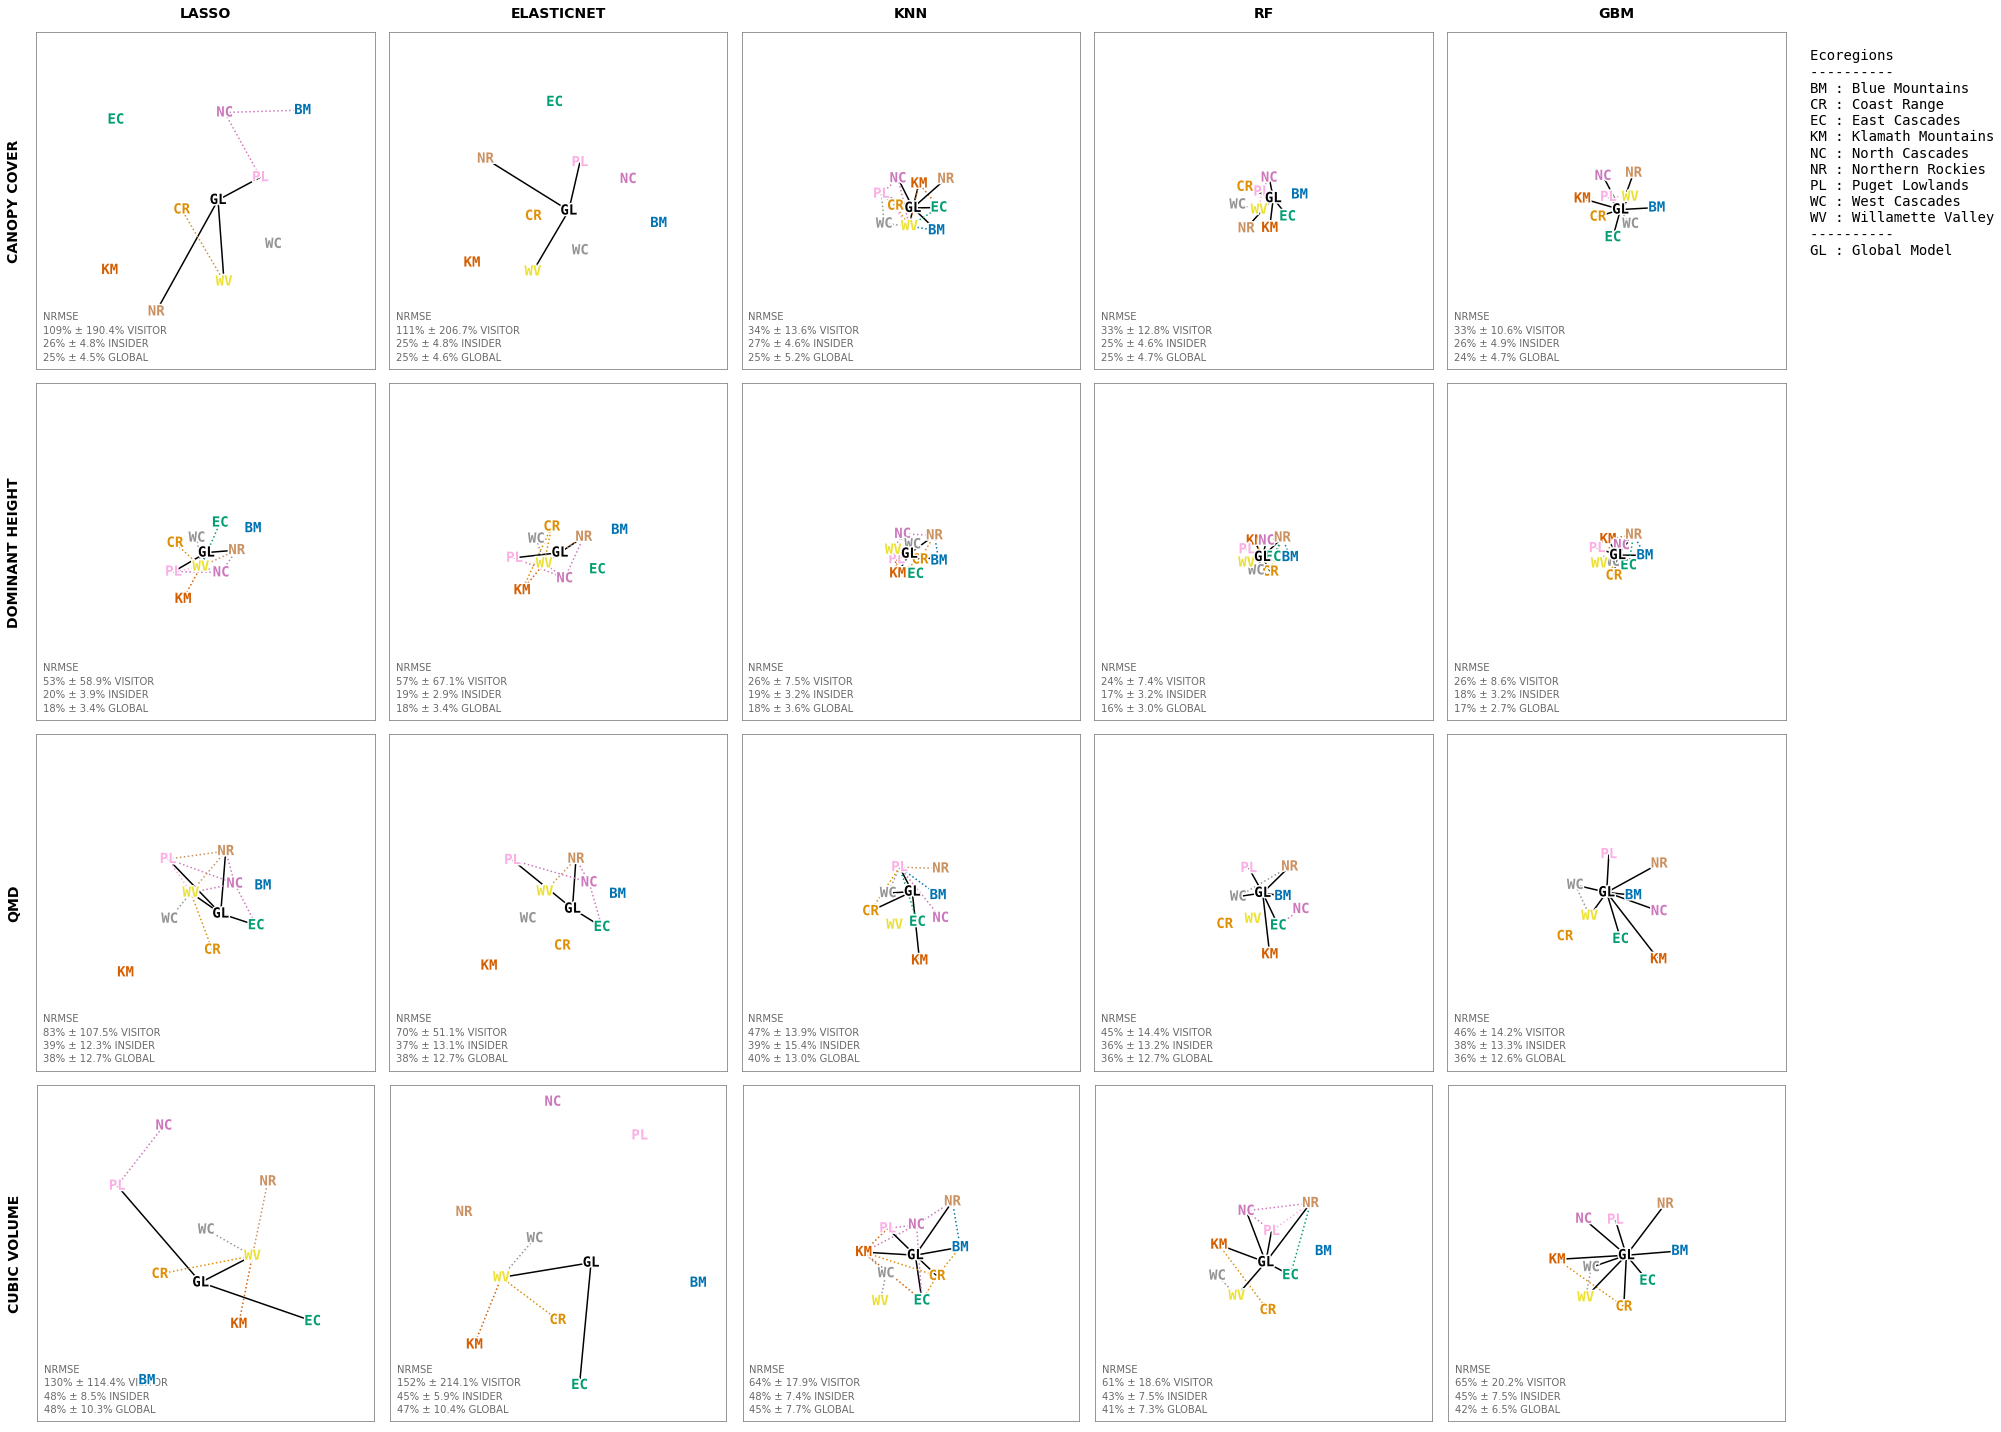

In [252]:
cmap = sns.color_palette('colorblind', n_colors=9)
cmap.append((0,0,0))

MODELS = ['Lasso', 'ElasticNet', 'kNN', 'RF', 'GBM']
# MODELS = ['GBM', 'RF', 'kNN']
REGIONS = ['BM', 'CR', 'EC', 'KM', 'NC', 'NR', 'PL', 'WC', 'WV', 'GL']
TARG_COLS = ['total_cover', 'topht', 'qmd', 'tcuft']
TARGETS = ['Canopy Cover', 'Dominant Height', 'QMD', 'Cubic Volume']
fig, axs = plt.subplots(len(TARG_COLS), len(MODELS), 
                        figsize=(25,20), 
                        sharex='row', sharey='row')
for col, model in enumerate(MODELS):
# for col, ds in enumerate(['lidar', 'satellite']):
    axs[0, col].set_title(model.upper(), fontsize=14, pad=15, fontweight='bold')
#     for k, mod in enumerate(MODELS):
    for k, ds in enumerate([
        'lidar', 
#         'satellite'
        ]):
        for targ_num, pt_set in enumerate(all_pts_2d[ds][model]):
#             pt_scale = euclidean_distances(pt_set)[euclidean_distances(pt_set)>0].mean()
#             err_scale = get_graph_df(TARG_COLS[targ_num], model, ds, metric='nrmse')['SCORE'].mean()
#             scale = pt_scale / err_scale
            scale = 1.0
            scaled_centroids = centroids.values * scale
            vis_mu, vis_sig, ins_mu, ins_sig, glo_mu, glo_sig = get_scales(TARG_COLS[targ_num], model, ds, metric='nrmse')
            vis_mu_mae, vis_sig_mae, ins_mu_mae, ins_sig_mae, glo_mu_mae, glo_sig_mae = get_scales(TARG_COLS[targ_num], model, ds, metric='mae')
            axs[targ_num, col].text(0.02, 0.17, 'NRMSE', 
                                    ha='left', va='top', 
                                    color='dimgray',
                                    transform=axs[targ_num, col].transAxes)
            axs[targ_num, col].text(0.02, 0.13, 
                                    f'{vis_mu:0.0%} ± {vis_sig:0.1%} VISITOR', 
                                    ha='left', va='top', 
                                    color='dimgray',
                                    transform=axs[targ_num, col].transAxes)
            axs[targ_num, col].text(0.02, 0.09,
                                    f'{ins_mu:0.0%} ± {ins_sig:0.1%} INSIDER', 
                                    ha='left', va='top', 
                                    color='dimgray', 
                                    transform=axs[targ_num, col].transAxes)
            axs[targ_num, col].text(0.02, 0.05,
                                    f'{glo_mu:0.0%} ± {glo_sig:0.1%} GLOBAL', 
                                    ha='left', va='top', 
                                    color='dimgray', 
                                    transform=axs[targ_num, col].transAxes)
            
            # get insider errors to plot around each region
            insider_errors = get_insider_error(TARG_COLS[targ_num], model, ds)
            global_errors = get_global_error(TARG_COLS[targ_num], model, ds)
            visitor_errors = get_visitor_error(TARG_COLS[targ_num], model, ds)
            for j, pts in enumerate(pt_set):
                axs[targ_num, col].scatter(pts[0]*scale, pts[1]*scale, color=cmap[j], s=0)
                t = axs[targ_num, col].text(pts[0]*scale, pts[1]*scale, 
                                            REGIONS[j], color=cmap[j], 
                                            fontweight='heavy',
                                            ha='center', va='center', 
                                            fontsize=14, family='monospace',
                                            path_effects=[path_effects.withStroke(linewidth=3,
                                                                                  foreground="w")]
                                           )
                # Plot insider error around each region
                if j < (len(pt_set)-1):
                    ins, glob = insider_errors.iloc[j]['SCORE'], global_errors.iloc[j]['SCORE']
#                     radius = insider_errors.iloc[j]['SCORE'] #* insider_errors.iloc[j]['SCORE']/global_errors.iloc[j]['SCORE']
#                     circle = plt.Circle((pts[0]*scale, pts[1]*scale), radius, facecolor='none', edgecolor=cmap[j], zorder=0, alpha=0.25)
#                     axs[targ_num, col].add_patch(circle)
                    # if global model is more accurate than insider model, plot a line between global and region
                    if glob < ins:
                        axs[targ_num, col].plot([pts[0]*scale, pt_set[-1][0]*scale], [pts[1]*scale, pt_set[-1][1]*scale], color=cmap[-1], lw=1.5, zorder=2)
                
                for k, reg in enumerate(REGIONS):
                    if j != k and j < (len(pt_set)-1) and k < (len(pt_set)-1):
                        train_err = visitor_errors.loc[(visitor_errors.TARGET_ECOREGION == REGIONS[j])&(visitor_errors.TRAIN_ECOREGION == REGIONS[k])]['SCORE'].values[0]
                        if train_err < ins:
                            axs[targ_num, col].plot([pts[0]*scale, pt_set[k][0]*scale], 
                                                    [pts[1]*scale, pt_set[k][1]*scale], 
                                                    ls=':',
                                                    color=cmap[k], lw=1.5, zorder=2)
                    
#                 # Plot scaled geographic centroids
#                 axs[targ_num, col].scatter(scaled_centroids[j,0], scaled_centroids[j,1], 
#                                     color=cmap[j], s=25.0)
#                 # Plot lines from each point to the geographic centroid
#                 axs[targ_num, col].plot([pts[0], scaled_centroids[j,0]], 
#                                 [pts[1], scaled_centroids[j,1]], 
#                                 color=cmap[j], lw=0.25)

            axs[i, col].set_aspect('equal')
            DIST = 1.5
            axs[targ_num, col].set_xlim(-DIST,DIST)
            axs[targ_num, col].set_ylim(-DIST,DIST)
            axs[targ_num, col].set_xticks([])
            axs[targ_num, col].set_yticks([])
            axs[targ_num, 0].set_ylabel(TARGETS[targ_num].upper(), fontsize=14, labelpad=15, fontweight='bold')
            axs[targ_num, col].spines['bottom'].set_color('gray')
            axs[targ_num, col].spines['top'].set_color('gray') 
            axs[targ_num, col].spines['right'].set_color('gray')
            axs[targ_num, col].spines['left'].set_color('gray')
plt.tight_layout()

axs[0,-1].text(0.75*DIST, DIST, 
        """
        Ecoregions
        ----------
        BM : Blue Mountains
        CR : Coast Range
        EC : East Cascades
        KM : Klamath Mountains
        NC : North Cascades
        NR : Northern Rockies
        PL : Puget Lowlands
        WC : West Cascades
        WV : Willamette Valley
        ----------
        GL : Global Model
        """, 
        fontsize=14, va='top', family='monospace')
plt.savefig('../reports/figures/lidar_transferability_by_target_and_model_kamada_kawai.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [70]:
get_distance_matrix('total_cover', 'ElasticNet', 'lidar', 'nrmse')

TARGET_ECOREGION,BM,CR,EC,KM,NC,NR,PL,WC,WV
TRAIN_ECOREGION,,,,,,,,,
BM,0.220756,2.628744,1.036867,1.965736,2.946274,1.019352,2.727483,2.273980,2.902401
CR,0.326207,0.205062,0.402671,0.310411,0.354603,0.418369,0.298618,0.245659,0.214491
EC,0.500760,3.742450,0.296714,0.667635,13.145442,1.841701,11.431334,3.141797,1.504353
KM,1.139548,0.336293,0.581517,0.281444,0.740325,1.186621,0.586474,0.401541,0.259575
NC,0.248664,0.354177,0.430385,0.586880,0.246226,0.504293,0.231141,0.377903,0.400813
NR,0.505140,0.334000,0.353973,0.508917,0.531143,0.347452,0.464267,0.362431,0.353483
PL,0.536858,0.414429,0.388288,0.724974,0.286256,0.526020,0.228126,0.410997,0.390990
WC,0.494809,0.250591,0.475223,0.351339,0.373491,0.648051,0.249222,0.229775,0.240988
WV,0.847184,0.323896,0.771515,0.365290,0.669040,1.288097,0.479558,0.334046,0.208739


In [71]:
get_global_distance_matrix('total_cover', 'ElasticNet', 'lidar', 'nrmse')

TARGET_ECOREGION,BM,CR,EC,KM,NC,NR,PL,WC,WV
TRAIN_ECOREGION,,,,,,,,,
GLOBAL,0.242859,0.21275,0.312566,0.28385,0.24904,0.323285,0.2062,0.236873,0.198028


In [72]:
def get_dist_matrix_with_global(target, model, data_source, metric):
    visiting = get_distance_matrix(target, model, data_source, metric)
    glob = get_global_distance_matrix(target, model, data_source, metric)
#     diff = visiting - glob.values
#     diff = diff.append(glob)
    
    return visiting.append(glob)

In [73]:
get_dist_matrix_with_global('total_cover', 'ElasticNet', 'lidar', 'nrmse')

TARGET_ECOREGION,BM,CR,EC,KM,NC,NR,PL,WC,WV
TRAIN_ECOREGION,,,,,,,,,
BM,0.220756,2.628744,1.036867,1.965736,2.946274,1.019352,2.727483,2.273980,2.902401
CR,0.326207,0.205062,0.402671,0.310411,0.354603,0.418369,0.298618,0.245659,0.214491
EC,0.500760,3.742450,0.296714,0.667635,13.145442,1.841701,11.431334,3.141797,1.504353
KM,1.139548,0.336293,0.581517,0.281444,0.740325,1.186621,0.586474,0.401541,0.259575
NC,0.248664,0.354177,0.430385,0.586880,0.246226,0.504293,0.231141,0.377903,0.400813
NR,0.505140,0.334000,0.353973,0.508917,0.531143,0.347452,0.464267,0.362431,0.353483
PL,0.536858,0.414429,0.388288,0.724974,0.286256,0.526020,0.228126,0.410997,0.390990
WC,0.494809,0.250591,0.475223,0.351339,0.373491,0.648051,0.249222,0.229775,0.240988
WV,0.847184,0.323896,0.771515,0.365290,0.669040,1.288097,0.479558,0.334046,0.208739
